In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import sys,os  
import cv2 
import caffe
from mvnc import mvncapi
from caffe import layers as CaffeLayers
from caffe.proto.caffe_pb2 import NetParameter, LayerParameter
import google.protobuf.text_format as txtf
import pandas as pd
import itertools
import random


Bad key "nbagg.transparent" on line 426 in
/home/polsecai/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_path" on line 509 in
/home/polsecai/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_args" on line 512 in
/home/polsecai/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution
In /home/polseca

Original Mobilenet-SSD VOC model from https://github.com/chuanqi305/MobileNet-SSD/blob/master/demo.py

In [2]:
net = caffe.Net('./models/deploy/ssd-mask.prototxt',
                './models/deploy/ssd-mask.caffemodel',
                caffe.TEST) 
class_labels = ('background', 'mask', 'unmask')

Define functions to transform input/output:

In [3]:
def transform_input(img, transpose=True, dtype=np.float32):
    inpt = cv2.resize(img, (300,300))
    inpt = inpt - 127.5
    inpt = inpt / 127.5
    inpt = inpt.astype(dtype)
    if transpose:
        inpt = inpt.transpose((2, 0, 1))
    return inpt

def transform_output(img, output):
    h,w = img.shape[:2] 
    boxes = (output['detection_out'][0,0,:,3:7] * np.array([w, h, w, h])).astype(int)
    classes = output['detection_out'][0,0,:,1].astype(int)
    confidence = output['detection_out'][0,0,:,2]
    if (len(confidence)==1) and (confidence[0]<0):
        return [],[],[]
    return boxes, classes, confidence

def transform_ncs_output(img, output, conf_thresh=0.5):
    """Get image and NCS output
    Return: boxes, classes, confidences"""
    num = int(output[0])
    scale = np.array([img.shape[1],img.shape[0],img.shape[1],img.shape[0]])
    t = [((e[3:].clip(0,1)*scale).astype(int), int(e[1]), e[2]) for e in output.reshape((-1,7))[1:] 
         if np.all(np.isfinite(e)) ][:num]
    #glitchy predictions with 1.0 confidence and 0 size in one/both dimensions appear sometimes
    #filter them too
    t = [e for e in t if (e[2]>conf_thresh) and (e[0][0]-e[0][2])*(e[0][1]-e[0][3])>0]
    return (zip(*t) if len(t)>0 else ([],[],[]))

Test it on several images

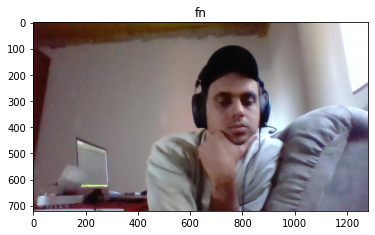

In [5]:

img = cv2.imread('jpg/fernando.jpg')

inpt = transform_input(img)
net.blobs['data'].data[...] = inpt
output = net.forward() 
boxes, classes, confidence = transform_output(img, output)

for box, cls, conf in zip(boxes, classes, confidence):
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
        txt = class_labels[int(cls)]+': %.3f' % float(conf)
        plt.text(max(box[0],30), max(box[1],30), txt, bbox=dict(facecolor='white', alpha=0.5))
plt.imshow(img[:,:,::-1])
plt.title("fn")
plt.show()

Measure time on CPU

In [6]:
%timeit net.forward()

281 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Use MVNC profiler to measure inference time (Neural Compute Stick must be plugged in)

In [7]:
! make profile_initial

cd models/ssd_voc_profile; \
mvNCProfile ../ssd_voc/deploy.prototxt -w ../ssd_voc/MobileNetSSD_deploy.caffemodel -s 12; \
cd ../..
/usr/local/bin/ncsdk/Controllers/Parsers/TensorFlowParser/Convolution.py:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(False, "Layer type not supported by Convolution: " + obj.type)
mvNCProfile v02.00, Copyright @ Intel Corporation 2017

/usr/local/bin/ncsdk/Controllers/FileIO.py:65: UserWarning: You are using a large type. Consider reducing your data sizes for best performance
Blob generated
USB: Transferring Data...
/usr/local/lib/python3.5/dist-packages/mvnc/mvncapi.py:420: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
Time to Execute :  98.83  ms
USB: Myriad Execution Finished
Time to Execute :  84.82  ms
USB: Myriad Execution Finished
USB: Myriad Connection Closing.
USB: Myriad Connection Closed.
Network Summary

Detailed Per Laye

Reproduce results on NCS:

/usr/local/lib/python3.5/dist-packages/mvnc/mvncapi.py:418: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  tensor = numpy.fromstring(tensor.raw, dtype=numpy.float32)


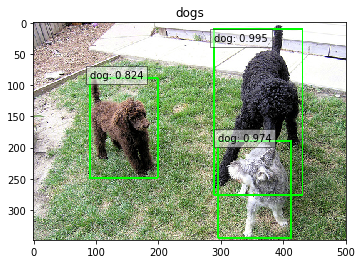

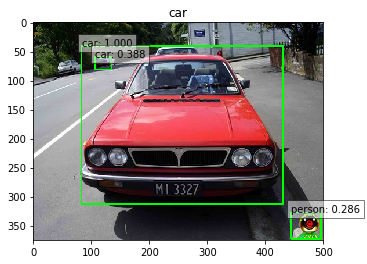

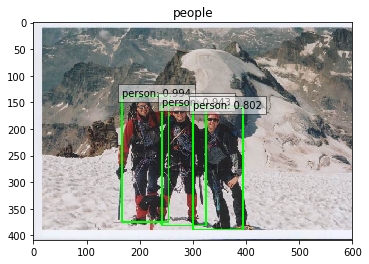

In [12]:
graph_path = './models/ssd_voc_profile/graph'

devices = mvncapi.enumerate_devices()
if len(devices) > 0:
    device = mvncapi.Device(devices[0])
    device.open()
    with open(graph_path, mode="rb") as f:
        graph_data = f.read()
    graph = mvncapi.Graph('graph_ssd')
    input_fifo, output_fifo = graph.allocate_with_fifos(device, graph_data)
    
    for fn in ['dogs', 'car', 'people']:
        img = cv2.imread('./images/'+fn+'.jpg')
        inpt = transform_input(img, False, np.float16)
        
        inpt = transform_input(img, False, np.float32)
        graph.queue_inference_with_fifo_elem(input_fifo, output_fifo, inpt, None)
        output, _ = output_fifo.read_elem()

        boxes, classes, confidence = transform_ncs_output(img, output, 0.25)

        for box, cls, conf in zip(boxes, classes, confidence):
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
            txt = class_labels[int(cls)]+': %.3f' % float(conf)
            plt.text(max(box[0],30), max(box[1],30), txt, bbox=dict(facecolor='white', alpha=0.5))
        plt.imshow(img[:,:,::-1])
        plt.title(fn)
        plt.show()

    input_fifo.destroy()
    output_fifo.destroy()
    graph.destroy()
    device.close()
    device.destroy()
else:
    print("No NCS device found")

Generate face images to test network

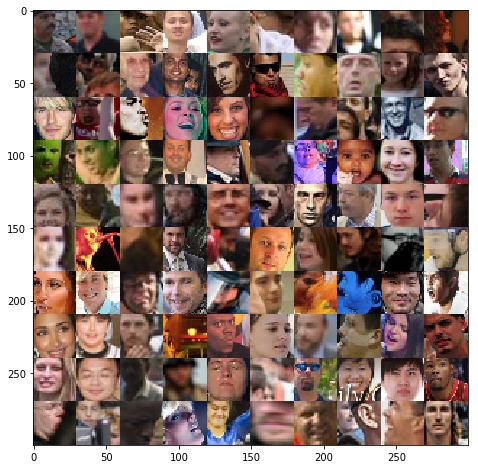

True

In [13]:
wider_path = '../../Datasets/WIDERfacedet/WIDER_train/images/'
np.random.seed(42)

wider_info = pd.read_csv('./data/wider.csv')
wider_info = wider_info.loc[wider_info.w>=30]
wider_info = wider_info.sample(frac=100/wider_info.shape[0])

faces = []
tmp = []
for cnt,i in enumerate(wider_info.index):
    x = wider_info.loc[i,'x']
    y = wider_info.loc[i,'y']
    w = int(wider_info.loc[i,'w']*np.random.uniform(1,2))
    img = cv2.imread(wider_path + wider_info.loc[i,'filename'])
    img = cv2.resize(img[y:y+w,x:x+w], (30,30))
    tmp.append(img)
    if cnt%10==9:
        faces.append(tmp)
        tmp = []
faces = [np.hstack(e) for e in faces]
faces = np.vstack(faces)
plt.figure(figsize=(8,8))
plt.imshow(faces[:,:,::-1])
plt.show()
cv2.imwrite('./images/faces.png', faces)

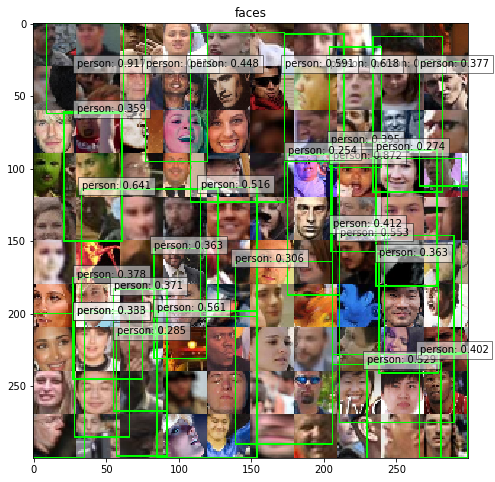

In [14]:
inpt = transform_input(faces)
net.blobs['data'].data[...] = inpt
output = net.forward() 
boxes, classes, confidence = transform_output(faces, output)
facecopy=faces.copy()

plt.figure(figsize=(8,8))
for box, cls, conf in zip(boxes, classes, confidence):
    cv2.rectangle(facecopy, (box[0], box[1]), (box[2], box[3]), (0,255,0), 1)
    txt = class_labels[int(cls)]+': %.3f' % float(conf)
    plt.text(max(box[0],30), max(box[1],30), txt, bbox=dict(facecolor='white', alpha=0.5))
plt.imshow(facecopy[:,:,::-1])
plt.title('faces')
plt.show()

Make face model by pruning network:

In [16]:
t = ! make face_model_full
t[-1]

'Model complete'

Profile obtained model:

In [17]:
t = ! make profile_face_full
print('\n'.join(t[-110:]))

I0915 21:48:42.847244  9532 net.cpp:228] data_input_0_split does not need backward computation.
I0915 21:48:42.847247  9532 net.cpp:228] input does not need backward computation.
I0915 21:48:42.847250  9532 net.cpp:270] This network produces output detection_out
I0915 21:48:42.847344  9532 net.cpp:283] Network initialization done.
/usr/local/bin/ncsdk/Controllers/Parsers/TensorFlowParser/Convolution.py:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(False, "Layer type not supported by Convolution: " + obj.type)
/usr/local/bin/ncsdk/Controllers/FileIO.py:65: UserWarning: You are using a large type. Consider reducing your data sizes for best performance
/usr/local/lib/python3.5/dist-packages/mvnc/mvncapi.py:420: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
mvNCProfile v02.00, Copyright @ Intel Corporation 2017

Blob generated
USB: Transferring Data...
Time to Execute

Demonstration of default bboxes in face model

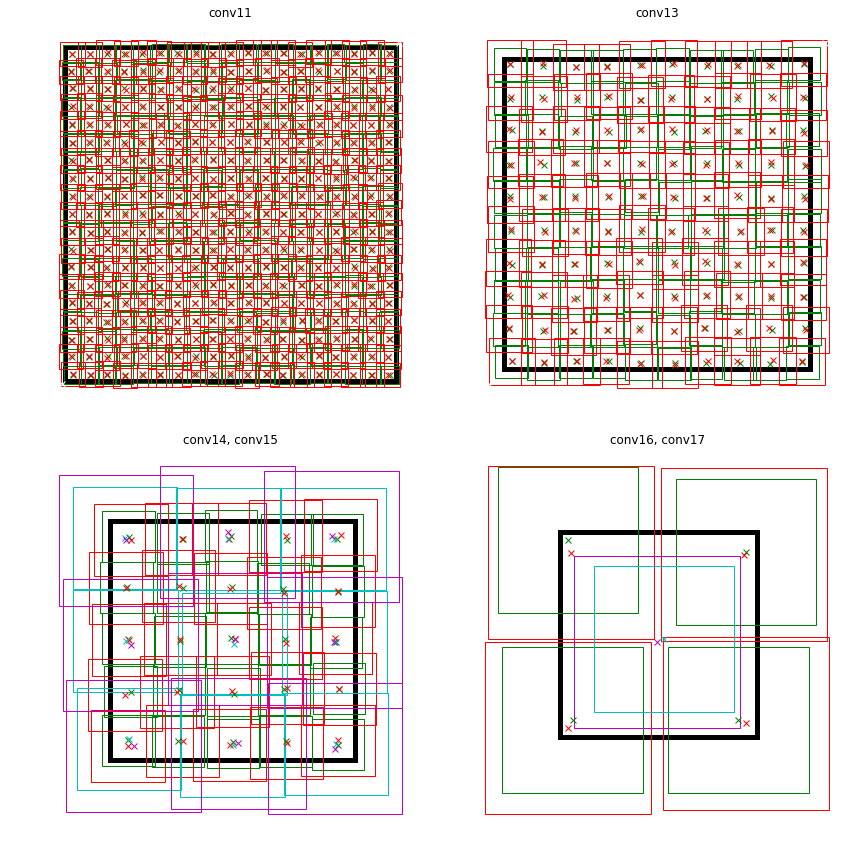

In [18]:
import matplotlib.patches as patches

def show_bboxes(ax, imsize, rand, expand, min_sizes, max_sizes, strides):
    ax.plot([-imsize*expand/2,imsize*expand/2], [-imsize*expand/2,imsize*expand/2], 'wx')
    rect = patches.Rectangle((-imsize/2,-imsize/2),imsize,imsize,linewidth=5,edgecolor='k',facecolor='none')
    ax.add_patch(rect)
    cols = ['b', 'g', 'r', 'c', 'm', 'y']
    col_ind = 0
    for s1,s2,s in zip(min_sizes, max_sizes, strides):
        for size in [s1,int(np.sqrt(s2*s1))]:
            col_ind = (col_ind+1)%len(cols)
            num = int(imsize/s)+1
            os = (imsize-(num-1)*s)/2-imsize/2
            for i in range(num):
                for j in range(num):
                    x = (os+i*s)+size*np.random.uniform(-rand,rand)
                    y = (os+j*s)+size*np.random.uniform(-rand,rand)
                    x1 = x-size/2
                    y1 = y-size/2
                    rect = patches.Rectangle((x1,y1),size,size,linewidth=1,edgecolor=cols[col_ind],facecolor='none')
                    ax.plot([x],[y],'x'+cols[col_ind])
                    ax.add_patch(rect)

f, axes = plt.subplots(2, 2, figsize=(12,12))
axes[0][0].axis('off')
axes[0][1].axis('off')
axes[1][0].axis('off')
axes[1][1].axis('off')
axes[0][0].set_title('conv11')
axes[0][1].set_title('conv13')
axes[1][0].set_title('conv14, conv15')
axes[1][1].set_title('conv16, conv17')
show_bboxes(axes[0][0],300,0.05,1.02,[16],[32],[16])
show_bboxes(axes[0][1],300,0.05,1.1,[32],[64],[32])
show_bboxes(axes[1][0],300,0.05,1.3,[64,128],[128,214],[64,128])
show_bboxes(axes[1][1],300,0.05,1.4,[214,214],[300,300],[256,512])
plt.tight_layout()
plt.show()